In [433]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [434]:
# Load in data

PATH = "../../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=["canceldate", "licence_registration_date", "golive_date"])

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

# Convert annual_revenue from a string to a float

df_raw['annual_revenue'] = pd.to_numeric(df_raw['annual_revenue'].str.replace(',', ''))

In [435]:
len(df_raw[df_raw['churned'] == 1]), len(df_raw[df_raw['churned'] == 0])

(3109, 2780)

In [436]:
df_raw.last_login_days.describe()

count    3121.000000
mean       26.167254
std        59.672898
min         0.000000
25%         0.000000
50%         0.000000
75%        13.000000
max       417.000000
Name: last_login_days, dtype: float64

In [437]:
df_raw.last_login_days.head()

0    NaN
1    0.0
2    1.0
3    3.0
4    0.0
Name: last_login_days, dtype: float64

In [438]:
df_raw.median()

days_active                          525.000
nps                                    5.000
last_login_days                        0.000
last_login_concern                     0.000
golive_days                            4.000
cases_total                            5.000
cases_open                             0.000
cases_closed                           0.000
cases_age_hours_total               1204.000
cases_age_hours_average              249.200
annual_revenue                     41429.995
interactions_total                     2.000
interactions_completed                 2.000
interactions_no_response               0.000
interactions_no_onboarding             0.000
interactions_completed_training        0.000
churn_concern_cases_total              1.000
churn_concern_cases_open               0.000
total_churn_concern_cases_age        455.000
churn_concern_cases_avg_hours        398.000
churned                                1.000
dtype: float64

In [439]:
df_raw.corr()

,days_active,nps,last_login_days,last_login_concern,golive_days,cases_total,cases_open,cases_closed,cases_age_hours_total,cases_age_hours_average,...,interactions_total,interactions_completed,interactions_no_response,interactions_no_onboarding,interactions_completed_training,churn_concern_cases_total,churn_concern_cases_open,total_churn_concern_cases_age,churn_concern_cases_avg_hours,churned
days_active,1.000000,-0.097737,-0.096769,-0.153696,0.249995,0.019800,-0.007551,-0.007551,-0.007017,-0.188971,...,-0.182730,-0.191028,0.020817,0.002035,-0.075420,-0.034957,-0.074099,0.063044,0.069753,-0.469021
nps,-0.097737,1.000000,-0.151421,-0.191716,-0.062551,0.174626,0.102944,0.102944,0.118550,-0.470709,...,0.122942,0.105714,0.002061,0.073759,0.055864,0.109406,0.083616,-0.321984,-0.323805,-0.201244
last_login_days,-0.096769,-0.151421,1.000000,0.676053,-0.073398,-0.198238,-0.180099,-0.180099,-0.167753,-0.179730,...,-0.096203,-0.049532,-0.111274,-0.025746,-0.038372,-0.047004,-0.127803,0.052497,0.055025,0.564677
last_login_concern,-0.153696,-0.191716,0.676053,1.000000,-0.100424,-0.250115,-0.220199,-0.220199,-0.190751,-0.174232,...,-0.103648,-0.055069,-0.104774,-0.040722,-0.041371,-0.104973,-0.098859,-0.008436,0.012302,0.588280
golive_days,0.249995,-0.062551,-0.073398,-0.100424,1.000000,0.019919,-0.003477,-0.003477,0.022107,-0.126672,...,0.115173,0.113277,0.038879,-0.040200,0.049719,-0.056676,0.017122,0.007349,0.024253,-0.248002
cases_total,0.019800,0.174626,-0.198238,-0.250115,0.019919,1.000000,0.689718,0.689718,0.802406,-0.214587,...,0.147795,0.094665,0.088284,0.078877,0.018998,0.077561,-0.015063,-0.100516,-0.127570,-0.186389
cases_open,-0.007551,0.102944,-0.180099,-0.220199,-0.003477,0.689718,1.000000,1.000000,0.804620,0.376898,...,0.142542,0.080417,0.106711,0.087675,0.013030,0.097718,0.230079,-0.128902,-0.158823,-0.218778
cases_closed,-0.007551,0.102944,-0.180099,-0.220199,-0.003477,0.689718,1.000000,1.000000,0.804620,0.376898,...,0.142542,0.080417,0.106711,0.087675,0.013030,0.097718,0.230079,-0.128902,-0.158823,-0.218778
cases_age_hours_total,-0.007017,0.118550,-0.167753,-0.190751,0.022107,0.802406,0.804620,0.804620,1.000000,0.526187,...,0.156631,0.106632,0.067252,0.094875,0.002382,0.051849,0.057316,-0.088305,-0.118000,-0.152284
cases_age_hours_average,-0.188971,-0.470709,-0.179730,-0.174232,-0.126672,-0.214587,0.376898,0.376898,0.526187,1.000000,...,0.095942,-0.011143,-0.057028,0.470256,NaN,NaN,NaN,0.905453,0.905453,-0.040428


In [440]:
# Convert fields to INT and setting any NaNs to the mean of that type
case_types = ['cases_total','cases_open','cases_closed','cases_age_hours_total','cases_age_hours_average', 'last_login_days']

for case_type in case_types:
    df_raw[case_type] = df_raw[case_type].fillna(df_raw[case_type].mean()).astype(int)

In [441]:
#df_raw.loc[df_raw.plan=='PLAN-S-19Q1', 'annual_revenue'].fillna(round(df_raw.annual_revenue[df_raw.plan == 'PLAN-S-19Q1'].mean(), 2))

In [442]:
plan_list = df_raw.plan[~pd.isnull(df_raw.plan)].unique()

for plan in plan_list:
    plan_revenue_mean = round(df_raw.annual_revenue[df_raw.plan == plan].mean(), 2)
    
    if pd.isnull(plan_revenue_mean):
        revenue = 0
    else:
        revenue = plan_revenue_mean
    df_raw.loc[df_raw.plan==plan, 'annual_revenue'] = df_raw.loc[df_raw.plan==plan, 'annual_revenue'].fillna(revenue)

In [443]:
import pandas as pd

def quick_analysis(df):
 print("Data Types:")
 print(df.dtypes)
 print("Rows and Columns:")
 print(df.shape)
 print("Column Names:")
 print(df.columns)
 print("Null Values:")
 print(df.apply(lambda x: sum(x.isnull()) / len(df)))
    
quick_analysis(df_raw)

Data Types:
username                                   object
merchant                                   object
canceldate                         datetime64[ns]
licence_registration_date          datetime64[ns]
days_active                                 int64
account_status                             object
customer_account_status                    object
nps                                       float64
licence_status                             object
cancel_reason                              object
cancel_details                             object
team                                       object
vertical                                   object
plan                                       object
last_login_days                             int64
last_login_concern                        float64
changing_platform                          object
new_platform                               object
salesperson                                object
golive_date                        dat

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c33ed8e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c3120b650>]], dtype=object)

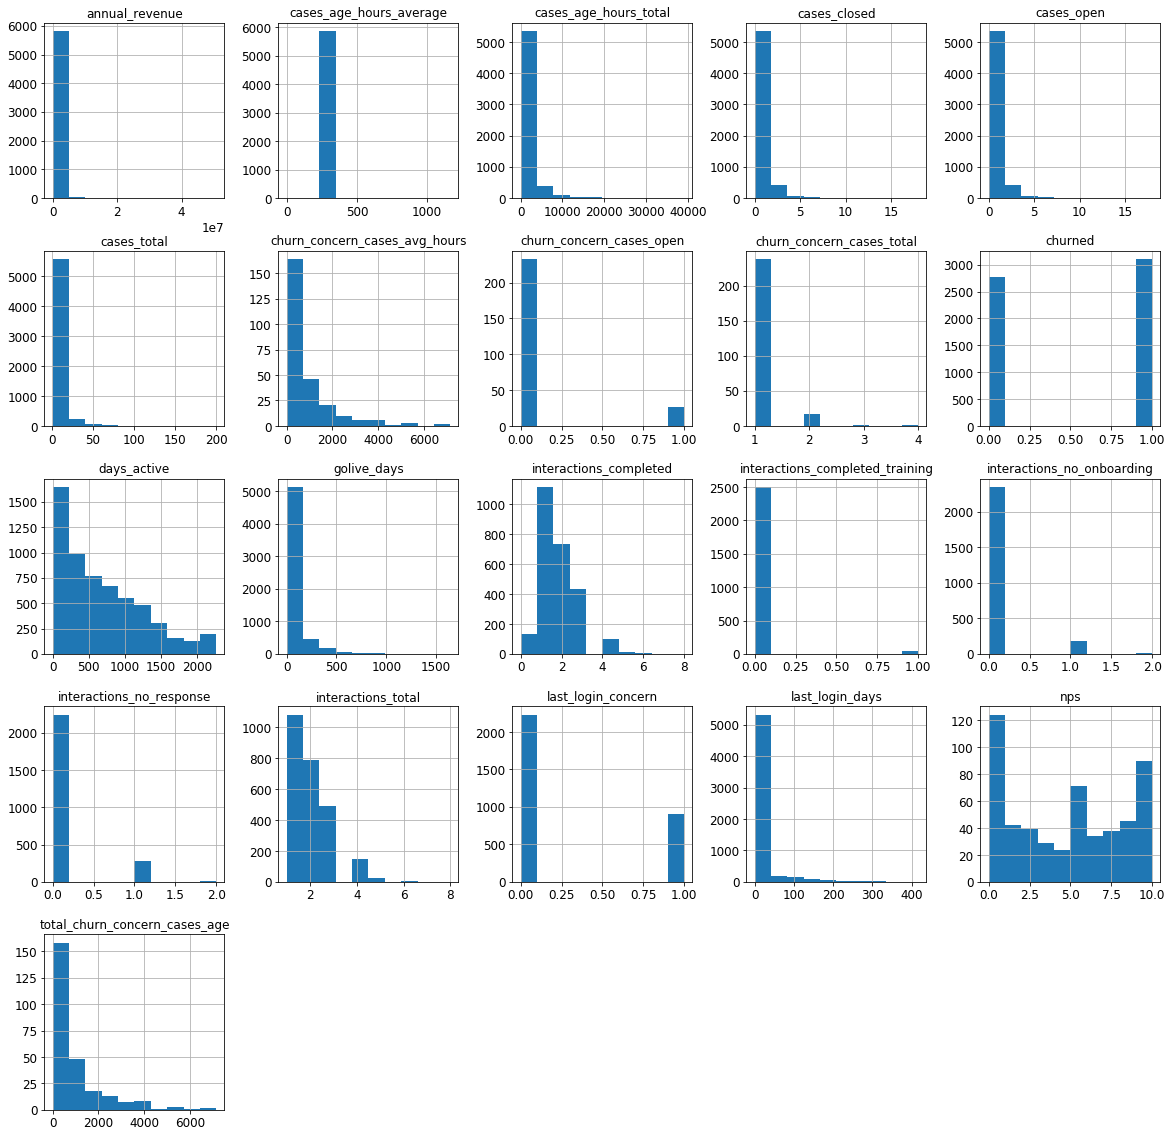

In [444]:
import matplotlib.pyplot as plt
df_raw[df_raw.dtypes[(df_raw.dtypes=="float64")|(df_raw.dtypes=="int64")]
                        .index.values].hist(figsize=[20,20])

In [445]:
# 'binning' - grouping continous data into 'bins'

bins = [1, 3, 7, 14, 30, 60]
group_names = ['day', 'few_days', 'week', 'fortnight', 'month']

# need to get the mean of the plan size for last_login_days and set each row to that
#df_raw.last_login_days = df_raw.last_login_days.fillna(np.mean(df_raw.last_login_days))

last_login_categories = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
df_raw['last_login_categories'] = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
pd.value_counts(df_raw['last_login_categories'])

fortnight    2882
few_days      174
month         143
week          125
day            80
Name: last_login_categories, dtype: int64

In [446]:
# A more standard way to one-hot encoding

dummy_columns = ['customer_account_status', 'last_login_categories', 'plan']

for dummy_column in dummy_columns:
    print(dummy_column)
    dummy = pd.get_dummies(df_raw[dummy_column], prefix=dummy_column)
    df_raw = pd.concat([df_raw,dummy], axis=1)
    df_raw = df_raw.drop(columns=dummy_column)

customer_account_status
last_login_categories
plan


In [447]:
df_raw.columns

Index(['username', 'merchant', 'canceldate', 'licence_registration_date',
       'days_active', 'account_status', 'nps', 'licence_status',
       'cancel_reason', 'cancel_details', 'team', 'vertical',
       'last_login_days', 'last_login_concern', 'changing_platform',
       'new_platform', 'salesperson', 'golive_date', 'golive_days', 'url',
       'cases_total', 'cases_open', 'cases_closed', 'cases_age_hours_total',
       'cases_age_hours_average', 'annual_revenue', 'interactions_total',
       'interactions_completed', 'interactions_no_response',
       'interactions_no_onboarding', 'interactions_completed_training',
       'churn_concern_cases_total', 'churn_concern_cases_open',
       'total_churn_concern_cases_age', 'churn_concern_cases_avg_hours',
       'churned', 'customer_account_status_Good',
       'customer_account_status_PoorStanding', 'last_login_categories_day',
       'last_login_categories_few_days', 'last_login_categories_week',
       'last_login_categories_fortnig

In [448]:
# These steps can only be run once then you need to comment them out

#add_datepart(df_raw, 'canceldate')
add_datepart(df_raw, 'licence_registration_date')
add_datepart(df_raw, 'golive_date')

In [450]:
# Drop columns

df_raw = df_raw.drop(columns=['customer_account_status_Good', 'last_login_concern',
                              'last_login_days', 'account_status', 'changing_platform', 
                              'new_platform', 'licence_status', 'canceldate', 
                              'cancel_details', 'cancel_reason'])



In [451]:
# this code was an attempt to do over sampling

#df_copy = df_raw.copy()
#df_copy.append([df_raw[df_raw.churn_concern==1]]*100,ignore_index=True)
#df_copy.append([df_raw[df_raw.churn_concern==0]]*100,ignore_index=True)
#len(df_copy[df_copy.churn_concern==1]), len(df_copy[df_copy.churn_concern==0]), len(df_copy)

In [453]:
# Set default values for NaN values

df_raw.nps = df_raw.nps.fillna(np.nanmean(df_raw.nps))


# Set NaN to zero

features = ['churned', 'interactions_total', 'interactions_completed', 'interactions_no_response', 'interactions_no_onboarding', 'interactions_completed_training']

for feature in features:
    df_raw[feature] = df_raw[feature].fillna(0)


In [454]:
# Complete the transformation of all data into numbers using proc_df and create training dataframes
train_cats(df_raw)
df_trn, y_trn, nas = proc_df(df_raw, 'churned')

In [455]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)

In [456]:
len(X_valid), len(X_valid.columns), len(X_train), len(X_train.columns)

(500, 103, 5389, 103)

In [457]:
y_train, y_valid = split_vals(y_trn, n_trn)
#raw_train, raw_valid = split_vals(df_raw, n_trn)
len(y_valid), len(y_train)

(500, 5389)

In [458]:
m = RandomForestClassifier(n_estimators=400, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True, max_depth=5)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [459]:
from sklearn.metrics import f1_score, accuracy_score

In [460]:
accuracy_score(y_valid, validate_predictions)

0.916

In [461]:
f1_score(y_valid, validate_predictions)

0.7586206896551724

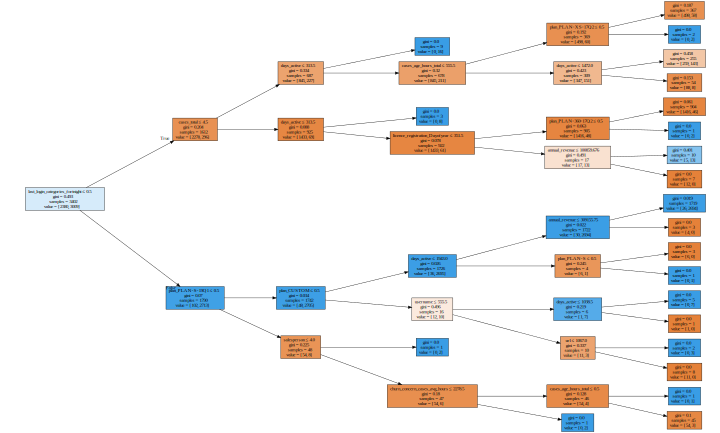

In [462]:
draw_tree(m.estimators_[10], df_trn, precision=3)

In [463]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
28,last_login_categories_fortnight,0.591339
15,interactions_total,0.109649
2,days_active,0.058795
16,interactions_completed,0.054104
60,plan_PLAN-S-19Q1,0.039161
12,cases_age_hours_total,0.030730
9,cases_total,0.019931
11,cases_closed,0.018494
14,annual_revenue,0.017685
10,cases_open,0.016001


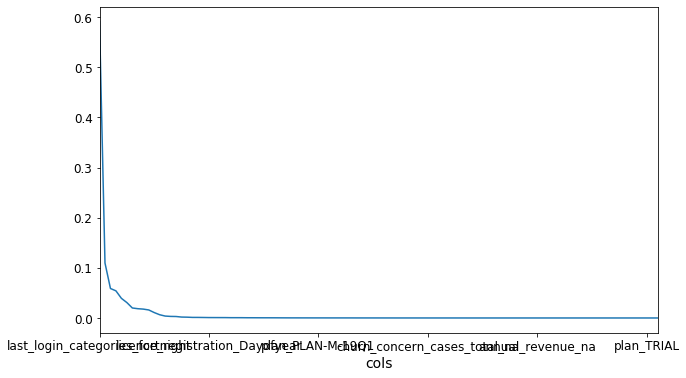

In [464]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [465]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

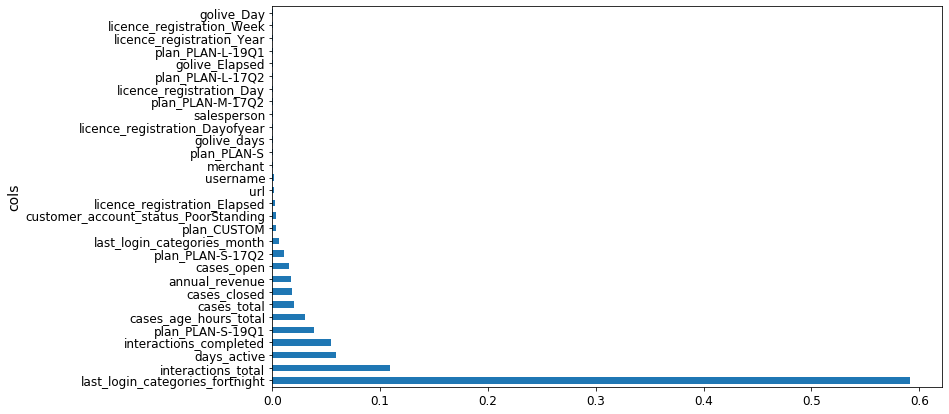

In [466]:
plot_fi(fi[:30]);

In [467]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

12

In [468]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [469]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train);
m.oob_score_

0.9484134347745408

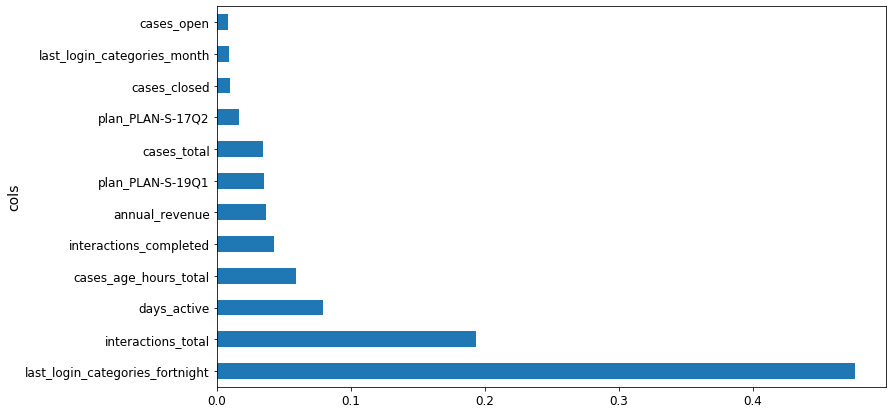

In [470]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [471]:
from scipy.cluster import hierarchy as hc

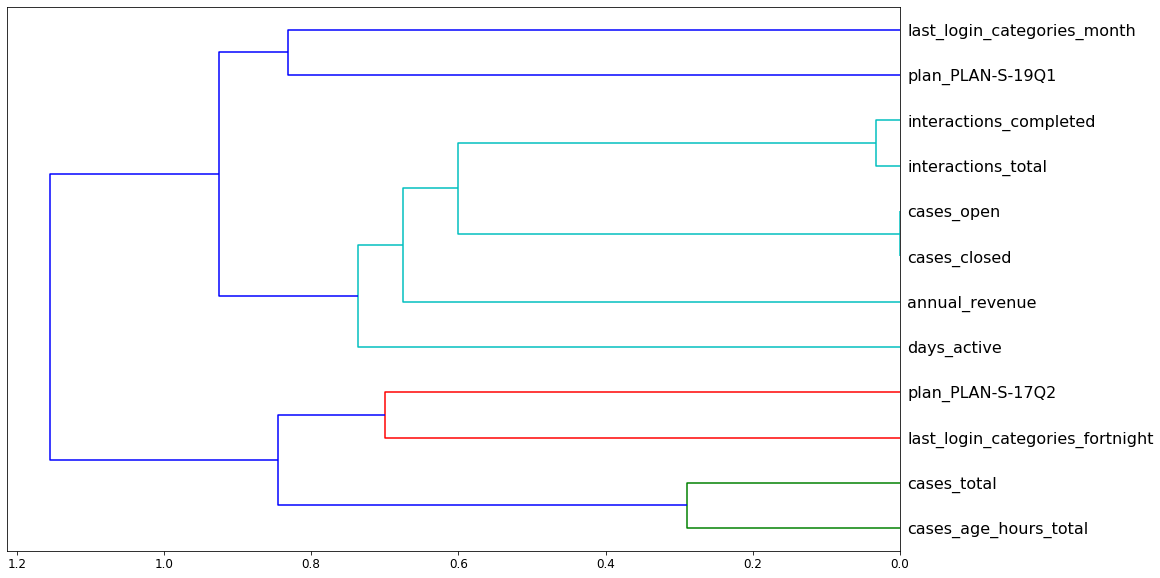

In [472]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [473]:
df_keep.columns

Index(['last_login_categories_fortnight', 'interactions_total', 'days_active',
       'interactions_completed', 'plan_PLAN-S-19Q1', 'cases_age_hours_total',
       'cases_total', 'cases_closed', 'annual_revenue', 'cases_open',
       'plan_PLAN-S-17Q2', 'last_login_categories_month'],
      dtype='object')

In [474]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [475]:
get_oob(df_keep)

0.9482278715902764

In [476]:
correlated_fields = ['cases_open', 'cases_closed']
for c in (df_keep):
    print(c, get_oob(df_keep.drop(c, axis=1)), get_oob(df_keep.drop(c, axis=1))-0.9660419372796437)

last_login_categories_fortnight 0.9393208387455929 -0.026535535349786588
interactions_total 0.9473000556689553 -0.017071812952310306
days_active 0.9482278715902764 -0.01688624976804598
interactions_completed 0.947856745221748 -0.01762850250510295
plan_PLAN-S-19Q1 0.9411764705882353 -0.02356652440155871
cases_age_hours_total 0.937836333271479 -0.029318983113750252
cases_total 0.9447021710892559 -0.0213397661903878
cases_closed 0.9482278715902764 -0.01911300797921689
annual_revenue 0.943217665615142 -0.02393765077008725
cases_open 0.9489701243273334 -0.01762850250510295
plan_PLAN-S-17Q2 0.9454444238263129 -0.01837075524215992
last_login_categories_month 0.9452588606420487 -0.0213397661903878


In [477]:
get_oob(df_keep.drop(correlated_fields, axis=1))

0.9460011133791056

In [478]:
to_drop = ['cases_closed']
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [479]:
m = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

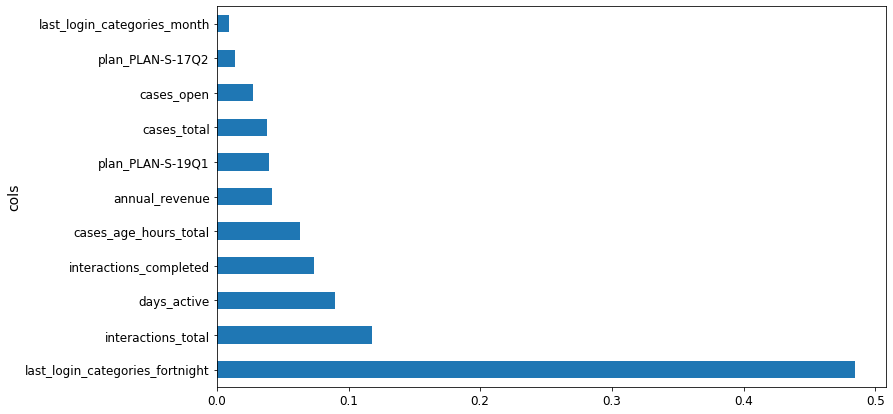

In [480]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [481]:
validate_predictions = m.predict(X_valid)
accuracy_score(y_valid, validate_predictions), f1_score(y_valid, validate_predictions)

(0.648, 0.45)